In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from poker_utils.constants import HANDS_DICT

In [2]:
base_data = pd.read_csv("data/raw/base_hand_data.csv")
blocker_data = pd.read_csv("data/raw/preflop_block_data.csv")

In [3]:
full_data = pd.concat([base_data.set_index('hand'), blocker_data.set_index('hand')], axis=1).reset_index()

In [4]:
cols = ['suited', 'pair', 'ace', 'broadway_score', 'low_pair',
       'medium_pair', 'high_pair', 'suited_broadway_score', 'connector', 'one_gap',
       'two_gap', 'suited_connector', 'suited_one_gap', 'suited_two_gap',
       'connectedness_score', 'rank_diff_score', 'high_card_score',
       'low_card_score', 'suited_connected_score', 'prem_blocker_score_norm', 
       'block_aa_score', 'block_kk_score']

In [5]:
ev_data = pd.read_csv('data/raw/ev_pca_data.csv').set_index("hand")

## Dataset Creation

In [6]:
class PreFlopDataset(Dataset):
    
    def __init__(self, preflop_df, feat_columns, ev_data):
        cols = ['hand','hand_idx'] + feat_columns
        self.data = preflop_df[cols].copy()
        self.feature_columns = feat_columns
        self.ev_data = ev_data
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        hand = row['hand']
        ev = self.ev_data.filter(regex='play').loc[hand]
        
        X_np = row[self.feature_columns].values.astype(np.float32)
        y_np = ev.values.astype(np.float32)
        return hand, torch.tensor(X_np, dtype=torch.float32), torch.tensor(y_np, dtype=torch.float32)

In [7]:
dataset = PreFlopDataset(full_data, cols, ev_data)

In [8]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=169)

## Model Training

In [9]:
class PredictivePreFlopEncoder(nn.Module):
    def __init__(self, input_size=22, embedding_dim=8):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, embedding_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 54)
        )
        
    def forward(self, x):
        embedding = self.encoder(x)
        ev_metrics = self.decoder(embedding)
        return embedding, ev_metrics

In [10]:
def train_model(model, dataloader, loss_func, optimizer, epochs=10):
    losses = []
    
    model.train()
    for epoch in range(epochs):
        for hands, features, evs in dataloader:
            optimizer.zero_grad()
            hand_embedding, ev_pred = model(features)
            total_loss = loss_func(predicted=ev_pred, actual=evs)
            total_loss.backward()
            optimizer.step()
            losses.append(total_loss.item())
        if epoch % (epochs//5) == 0:
            print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss.item():.4f}")
    
    return losses

In [11]:
def loss_function(actual, predicted):
    return F.mse_loss(predicted, actual)

In [12]:
def plot_train_loss(train_res, figsize=(5,5)):
    epochs = len(train_res)
    plt.figure(figsize=figsize)
    plt.plot(range(epochs), train_res, 'b-', label='Total Loss')
    plt.title('Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [13]:
model = PredictivePreFlopEncoder(embedding_dim=8)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

Epoch 1/100, Total Loss: 0.4082
Epoch 21/100, Total Loss: 0.1330
Epoch 41/100, Total Loss: 0.0427
Epoch 61/100, Total Loss: 0.0176
Epoch 81/100, Total Loss: 0.0099


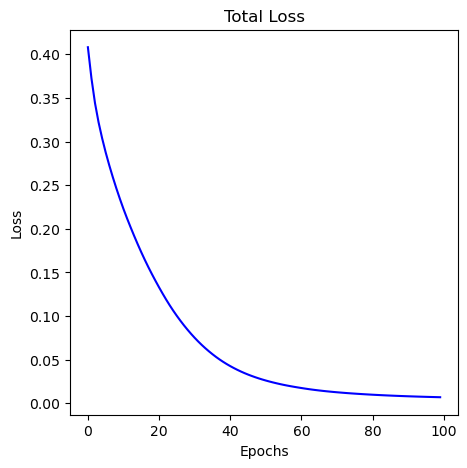

In [14]:
train_res = train_model(model, dataloader, 
                        loss_func=loss_function, optimizer=optimizer,epochs=100)
plot_train_loss(train_res)

In [15]:
# torch.save(model.state_dict(), "model_weights/preflop_predictive_encoder_weights.pth")

## Feature Importances

In [16]:
initial_layer_weights = model.encoder[0].weight.data
feature_importance = torch.mean(torch.abs(initial_layer_weights), dim=0)

In [17]:
importance_dict = {name: float(importance) for name, importance in zip(dataset.feature_columns, feature_importance)}
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

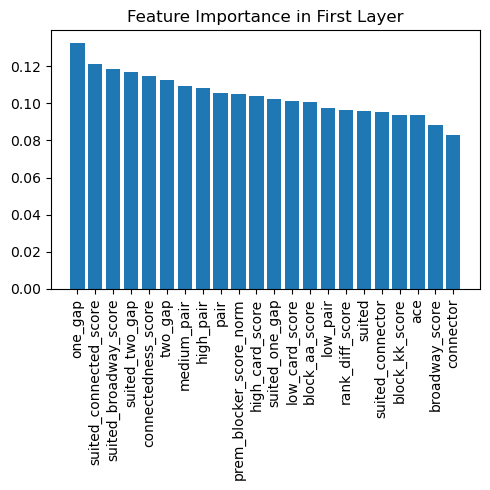

In [18]:
plt.figure(figsize=(5, 5))
features, values = zip(*sorted_importance)
plt.bar(features, values)
plt.xticks(rotation=90)
plt.title("Feature Importance in First Layer")
plt.tight_layout()
plt.show()

In [19]:
hands, features, evs = next(iter(dataloader))

In [40]:
model.eval()
with torch.no_grad():
    embeddings, ev_pred = model(features)

## Prediction Error Analysis

In [41]:
squared_error = (ev_pred - evs) ** 2

In [42]:
error_df = pd.DataFrame(squared_error)
error_df.columns = ev_data.filter(regex='play').columns
error_df.index = hands

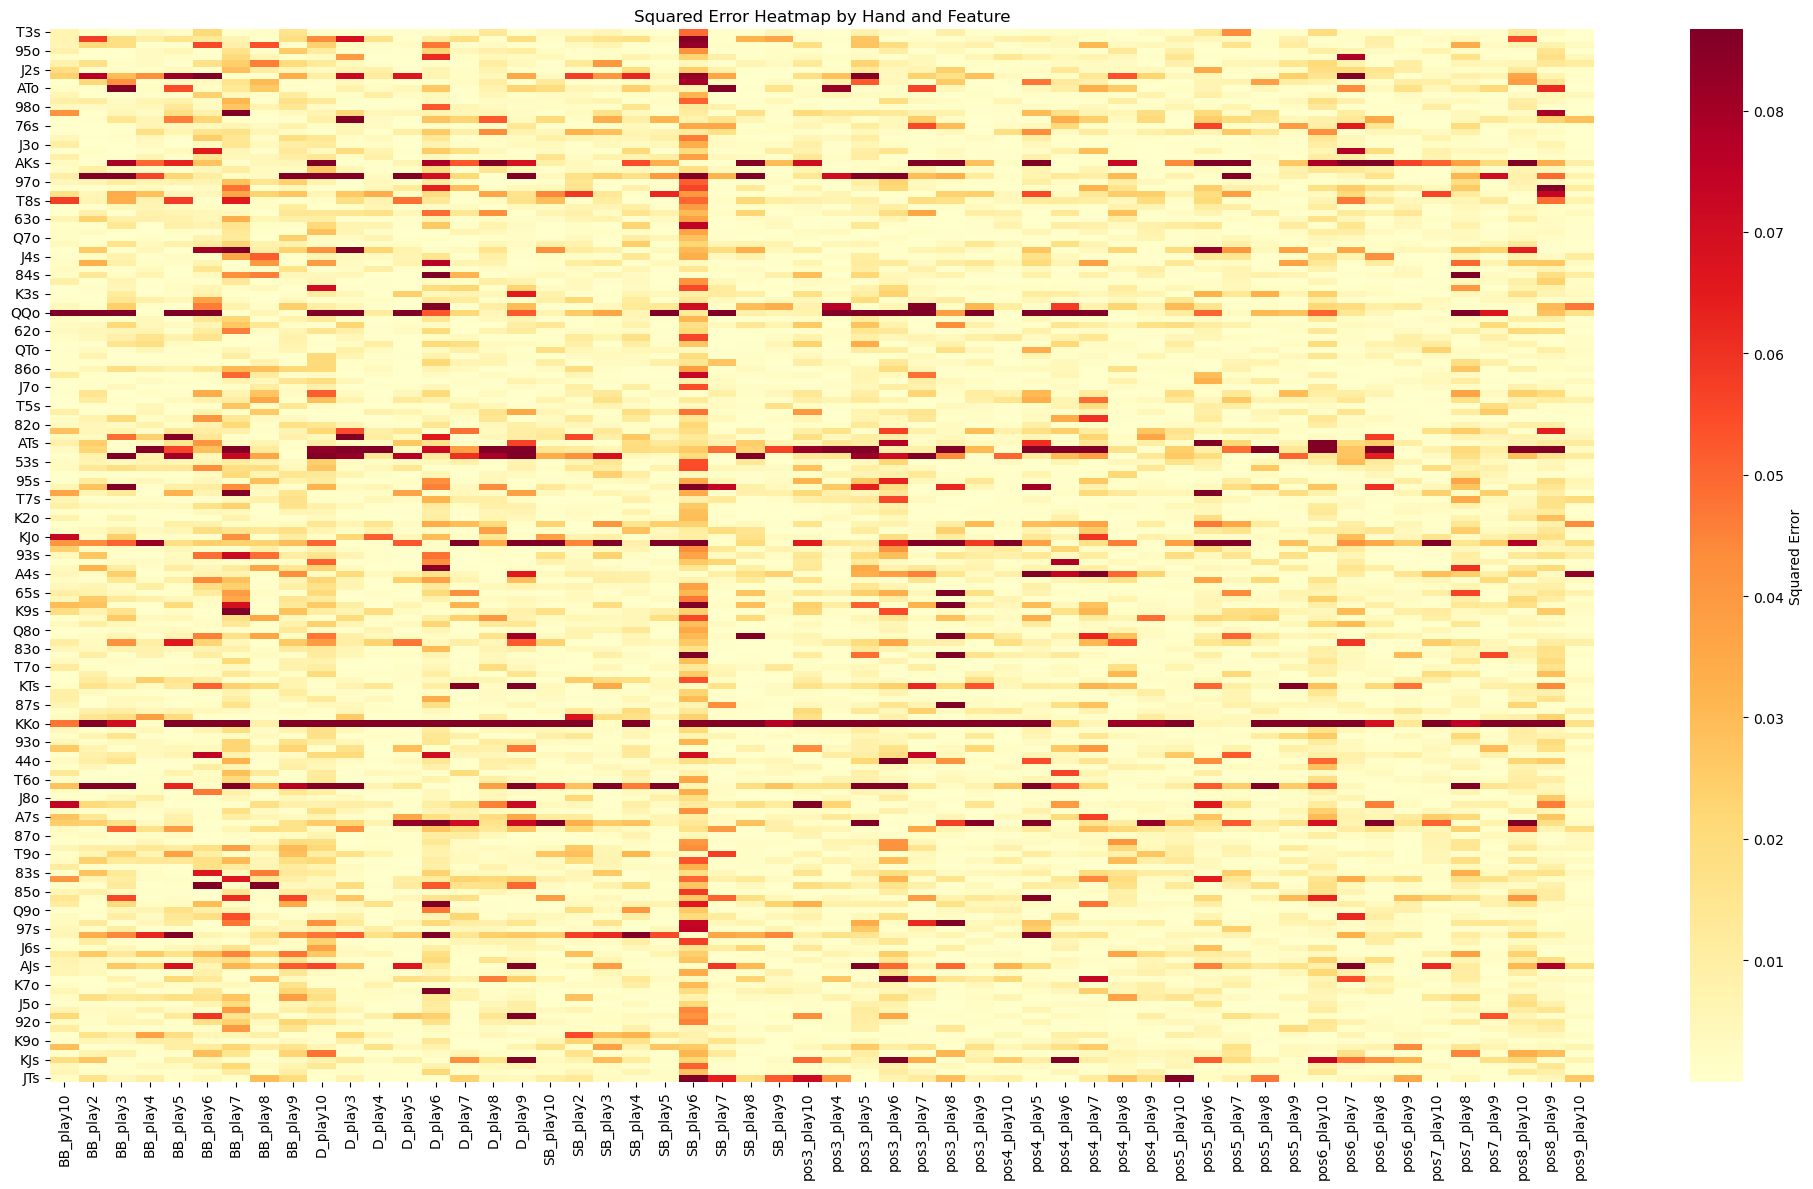

In [43]:
plt.figure(figsize=(20, 12))

ax = sns.heatmap(error_df, 
                 cmap='YlOrRd',
                 robust=True,
                 cbar_kws={'label': 'Squared Error'})

plt.title('Squared Error Heatmap by Hand and Feature')
plt.tight_layout()
plt.show()

## Similarity Analysis

In [44]:
similarity_df = pd.DataFrame(cosine_similarity(embeddings))
similarity_df.columns = hands
similarity_df.index = hands


In [45]:
similarity_df.loc['AAo'].sort_values(ascending=False).head(5)

AAo    1.000000
QQo    0.835182
JJo    0.774280
AKo    0.527596
TTo    0.338584
Name: AAo, dtype: float32

In [46]:
similarity_df.loc['75s'].sort_values(ascending=False).head(5)

75s    1.000000
86s    0.997499
64s    0.997343
97s    0.991947
85s    0.990045
Name: 75s, dtype: float32

In [47]:
similarity_df.loc['A4s'].sort_values(ascending=False).head(5)

A4s    1.000000
AJo    0.838355
A4o    0.830935
A2o    0.817027
ATo    0.814779
Name: A4s, dtype: float32

In [48]:
similarity_df.loc['33o'].sort_values(ascending=False).head(5)

33o    1.000000
44o    0.996836
22o    0.996479
55o    0.983560
QTo    0.943076
Name: 33o, dtype: float32

In [49]:
similarity_df.loc['72o'].sort_values(ascending=False).head(5)

72o    1.000000
82o    0.999793
73o    0.999511
62o    0.999335
T5o    0.999262
Name: 72o, dtype: float32

In [50]:
similarity_df.loc['76s'].sort_values(ascending=False).head(5)

76s    1.000000
87s    0.999980
65s    0.999973
54s    0.999944
98s    0.999915
Name: 76s, dtype: float32

## Embedding Analysis

In [51]:
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.index = hands

In [52]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

In [53]:
embeddings_2d_df = pd.DataFrame(embeddings_2d)
embeddings_2d_df.index = hands
embeddings_2d_df.columns = ['PC1','PC2']

In [54]:
pca_df = pd.concat([base_data.set_index('hand'), embeddings_2d_df], axis=1).reset_index()
pca_df.rename({'index':'hand'},axis=1, inplace=True)

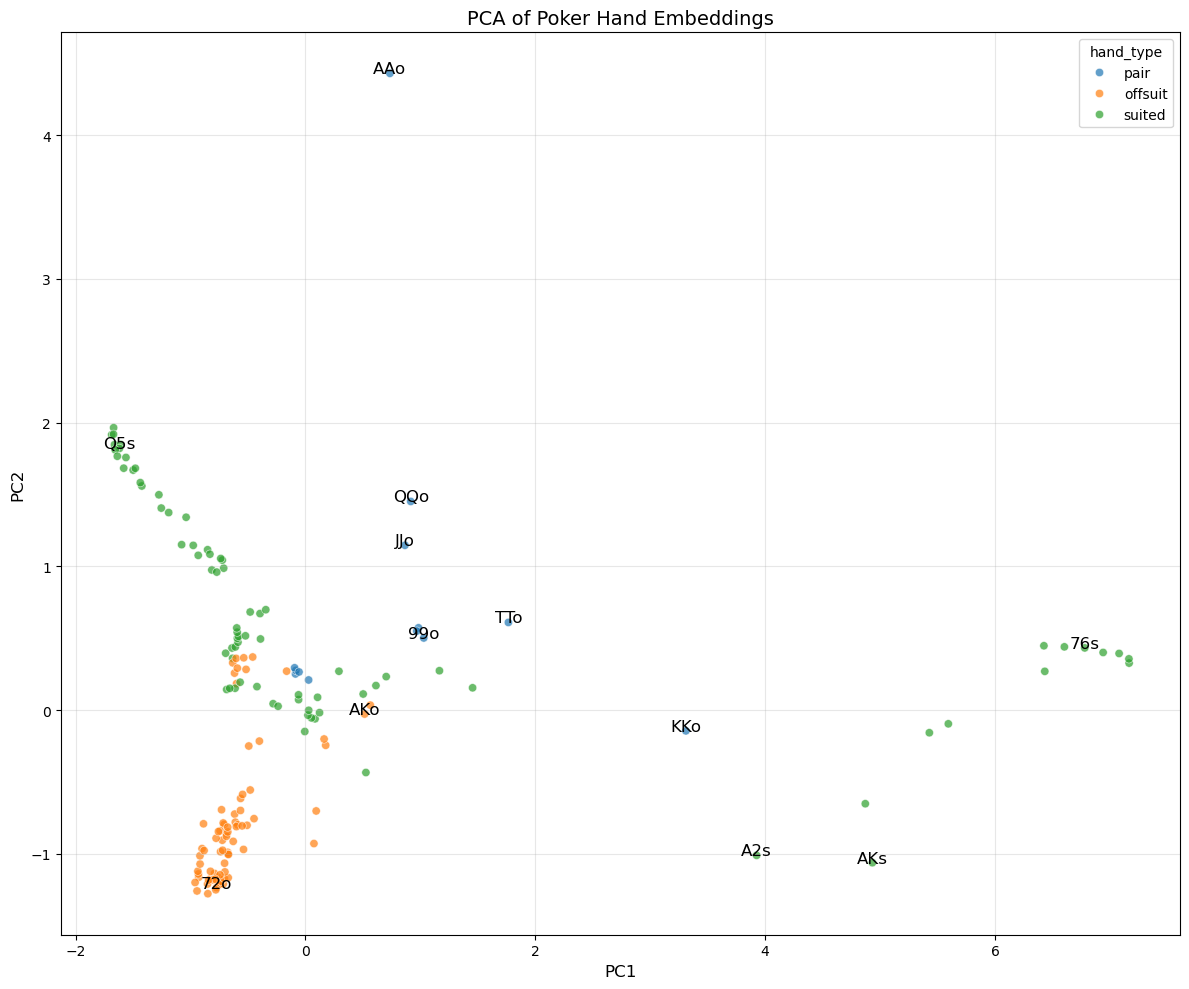

In [55]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='hand_type', alpha=0.7)

key_hands = ['AAo', 'KKo', 'QQo', 'AKs', 'AKo', 'JJo', 'TTo', 'A2s', '72o', 'Q5s','76s', '99o']
for hand in key_hands:
    if hand in pca_df['hand'].values:
        row = pca_df[pca_df['hand'] == hand].iloc[0]
        plt.annotate(hand, (row['PC1'], row['PC2']), fontsize=12, ha='center')

plt.title('PCA of Poker Hand Embeddings', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [56]:
embeddings_df['hand_idx'] = [{j: i for i,j in HANDS_DICT.items()}[hand] for hand in hands]

In [57]:
sorted_embeddings_np = embeddings_df.sort_values(by='hand_idx').iloc[:,:-1].to_numpy()

In [ ]:
# torch.save(torch.tensor(sorted_embeddings_np), 'model_weights/preflop_embeddings.pt')